# ADS - Network analysis module. Homework 2

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


load assignment data

In [2]:
dataA=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/homework2/networkA.csv' , header=0 )
XY=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/homework2/networkA_XY.csv' , header=0 )

In [3]:
dataB=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/homework2/networkB.csv' , header=0 )
PB=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/homework2/PB.csv' , header=0 )

## Problem 1 (20% of credit)

Find and visualize shortest path between nodes 1 and 20 in the above spatial network A in terms of
a) network topology
b) spatial distance

In [4]:
graph1 = nx.DiGraph()
for i in dataA.index:
       graph1.add_edge(dataA.a[i],dataA.b[i])#, weight=dataA.w[i])

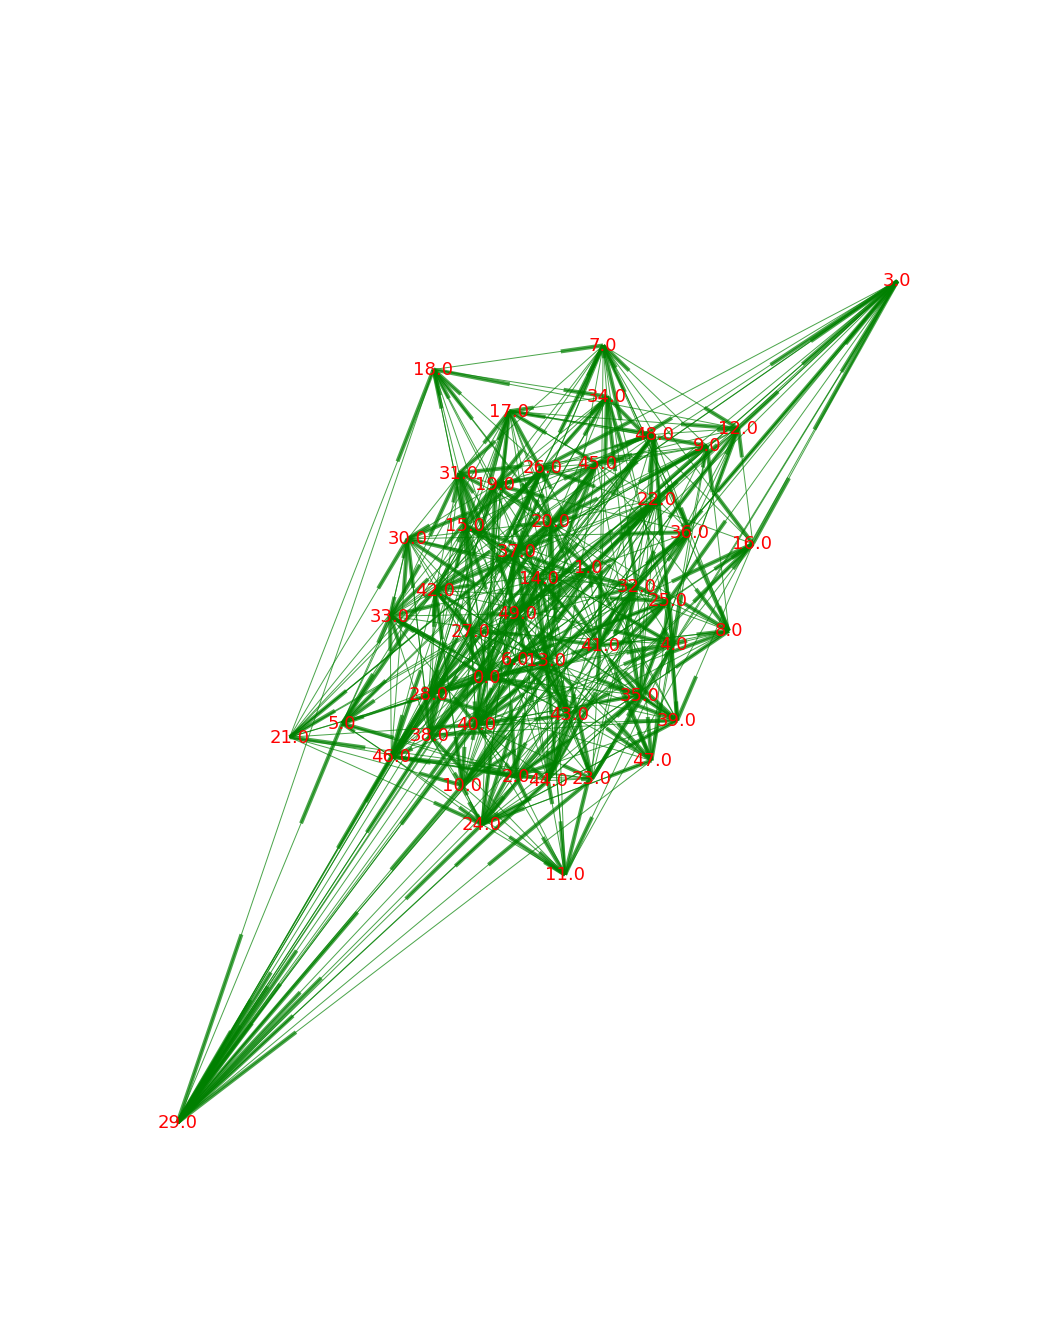

In [5]:
plt.figure(figsize = (14,18))
nx.draw(graph1, with_labels = True, alpha = 0.7, font_size = 18, 
        node_size = 0, font_color = 'r',edge_color = 'g')

In [6]:
shrtpath_a = nx.shortest_path(graph1, graph1.nodes()[1], graph1.nodes()[20])
print len(shrtpath_a)

3


In [7]:
IntPos={}
for c in XY.index:
    IntPos[c]=(XY.X[c],XY.Y[c])

In [8]:
def visualize_path(path, graph):
    plt.figure(figsize = (14,18))
    nx.draw(graph, pos = IntPos, with_labels = True, alpha = 0.4, font_size = 18, 
            node_size = 0, font_color = 'r', edge_color = 'g')
    x=[IntPos[v][0] for v in path]
    y=[IntPos[v][1] for v in path]
    plt.plot(x,y,'bo-', lw = 7)
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=14)

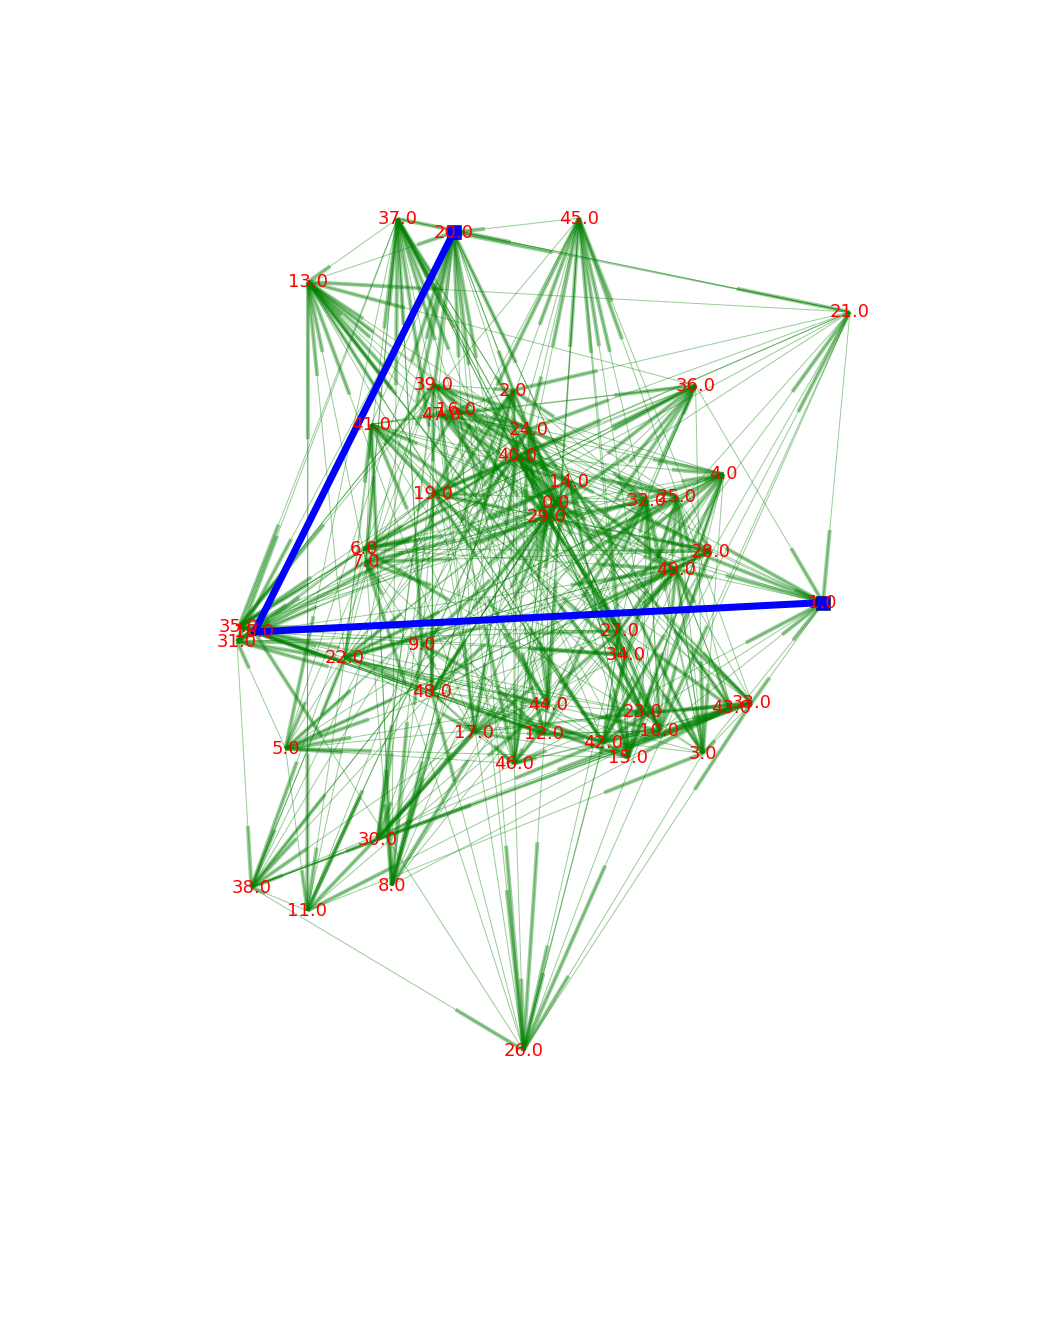

In [9]:
visualize_path(shrtpath_a, graph1)

In [10]:
graph2 = nx.DiGraph()
for i in dataA.index:
       graph2.add_edge(dataA.a[i], dataA.b[i], weight = dataA.w[i])

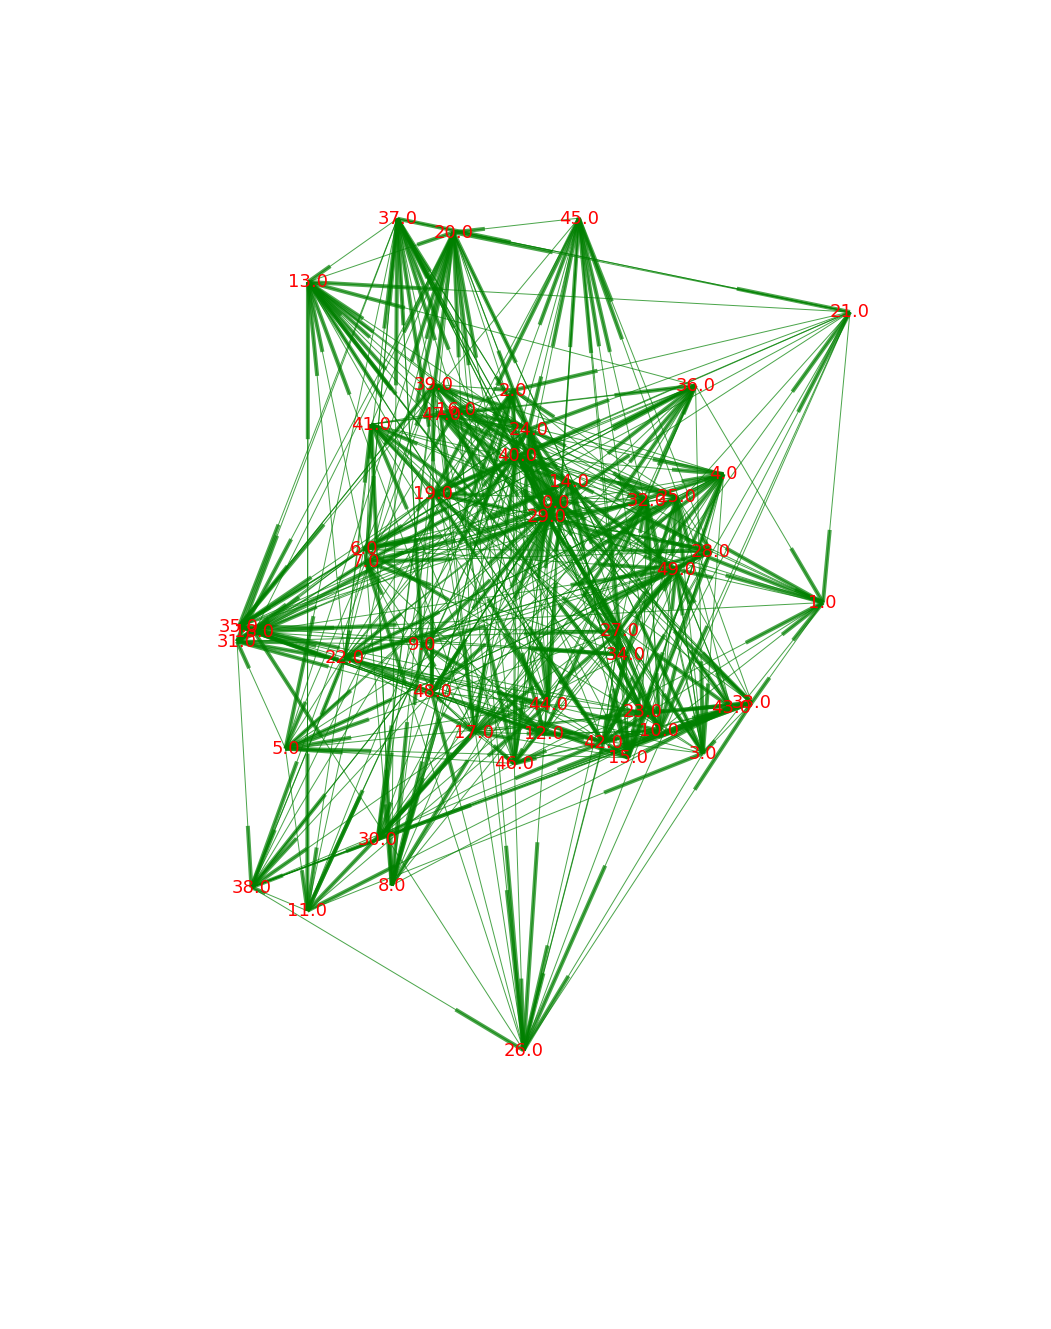

In [11]:
plt.figure(figsize = (14,18))
nx.draw(graph2, pos=IntPos, with_labels = True, alpha = 0.7, font_size = 18, 
        node_size = 0, font_color = 'r', edge_color ='g')

In [12]:
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [13]:
nx.set_edge_attributes(graph2, 'dist', 0)

In [14]:
for e in graph2.edges():
    graph2[e[0]][e[1]]['dist']=geodist(IntPos[e[0]][0],IntPos[e[0]][1],IntPos[e[1]][0],IntPos[e[1]][1])

In [15]:
shrtpath_b = nx.shortest_path(graph2, graph2.nodes()[1], graph2.nodes()[20], 'dist')
print len(shrtpath_b)

5


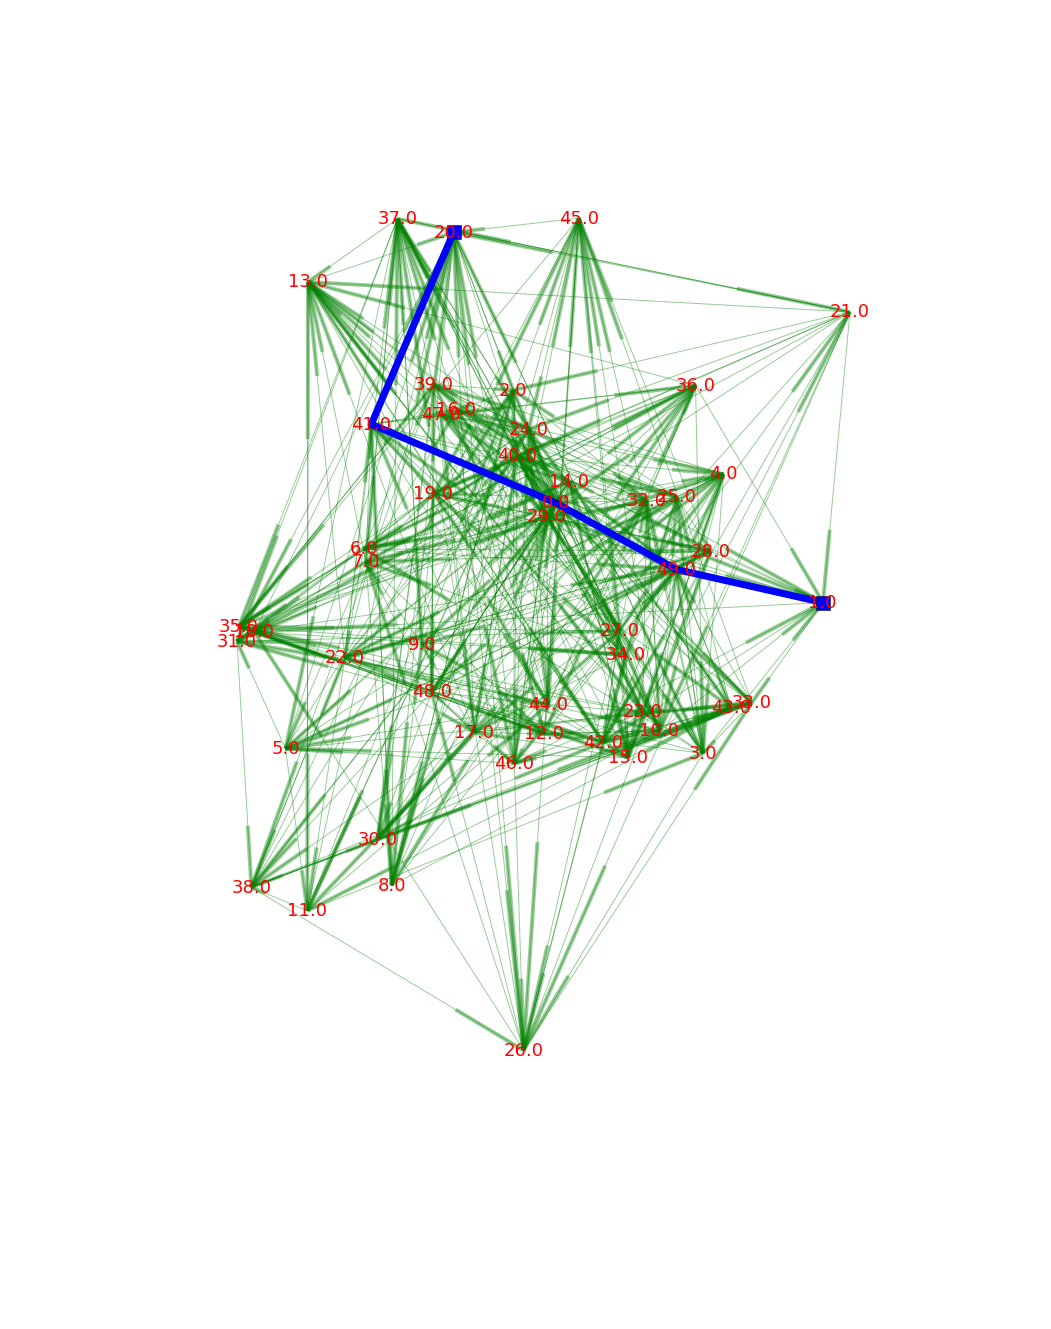

In [16]:
visualize_path(shrtpath_b, graph2)

In [17]:
shrtpath_c = nx.shortest_path(graph2, graph2.nodes()[1], graph2.nodes()[20], 'weight')
print len(shrtpath_c)

4


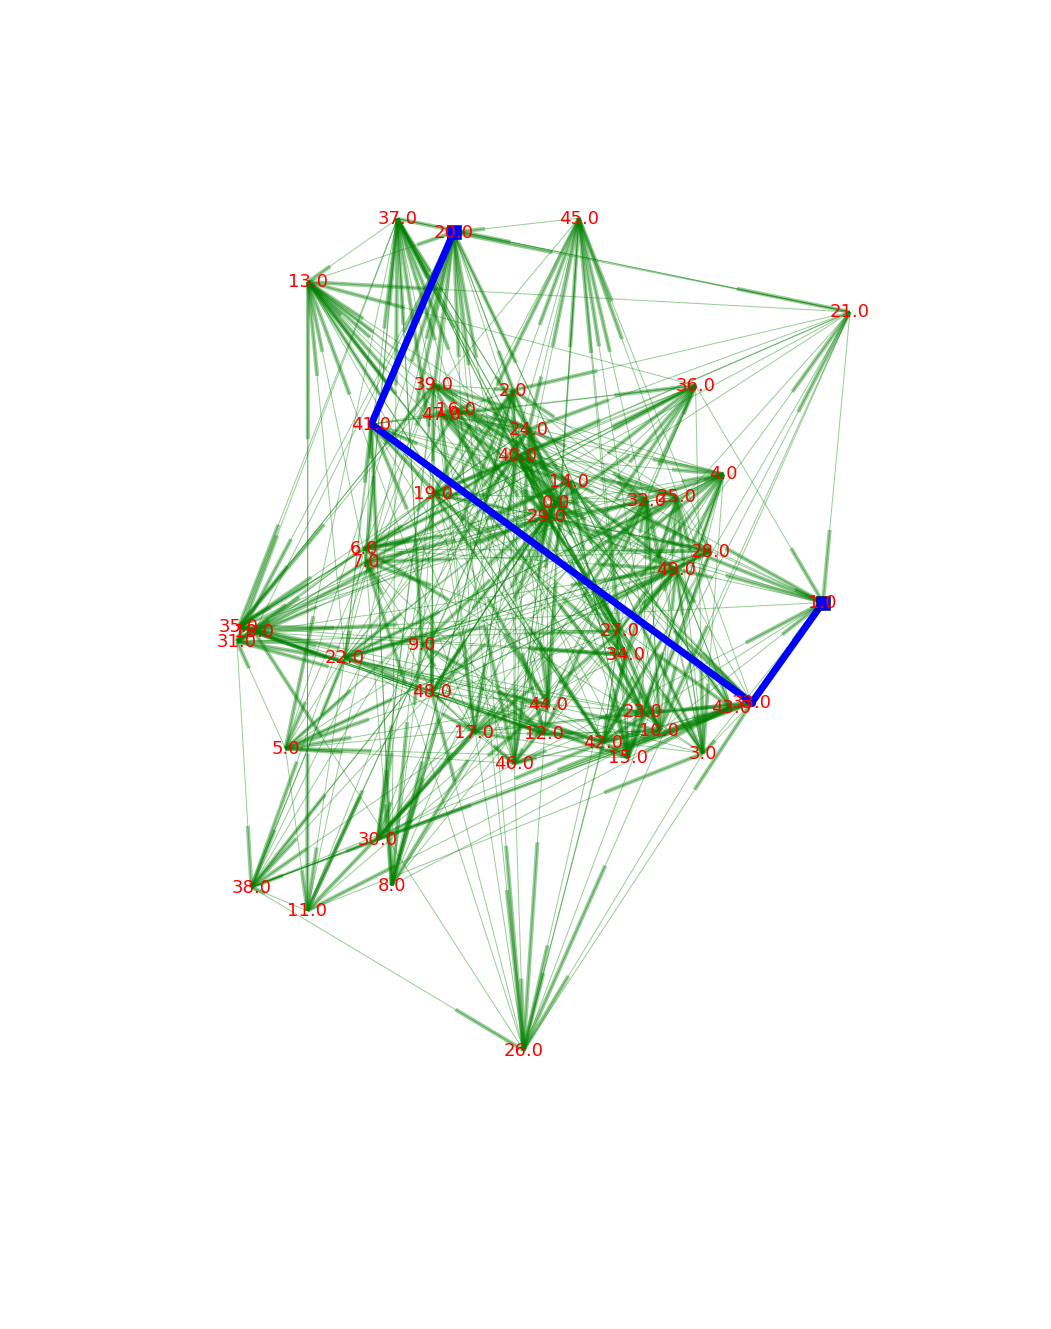

In [18]:
visualize_path(shrtpath_c, graph2)

## Problem 2 (20% of credit)

In the above spatial network A (defined by a weighted edge list dataA and nodes spatial locations XY) find the pair of nodes with the higest shortest path length between them in terms of network topology. Visualize the shortest path between the two nodes

In [19]:
# All shortest paths
shrtpaths = nx.all_pairs_shortest_path(graph2)

# Find the longest path
highest = None
length = 0
for a in shrtpaths:
    for b in shrtpaths[a]:
        if len(shrtpaths[a][b]) > length:
            highest = (a,b)
            length = len(shrtpaths[a][b])
print 'The highest shortest path goes through nodes', shrtpaths[highest[0]][highest[1]]

The highest shortest path goes through nodes [0.0, 4.0, 7.0, 19.0]


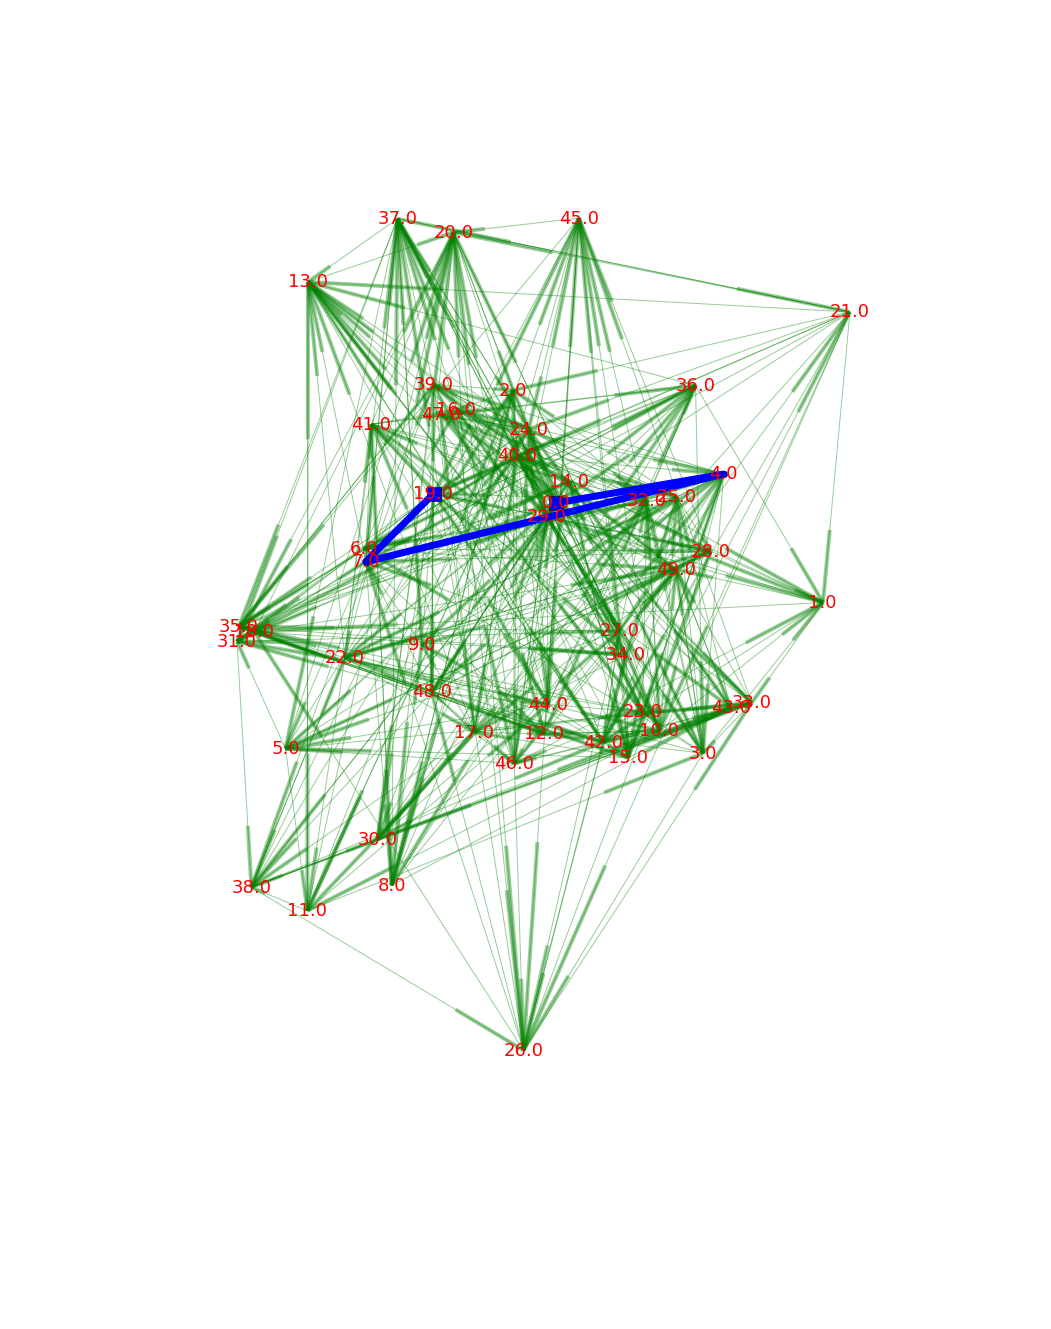

In [20]:
visualize_path(shrtpaths[highest[0]][highest[1]], graph2)

In [21]:
d1 = nx.shortest_path_length(graph2, weight='weight')
k = []
for i in range(50):
    d = nx.shortest_path_length(graph2, weight='weight')[i]
    k.append(max(d, key = d.get))
k= pd.DataFrame({'m':k})
count=0
a={}
for c in k.index:
    count += 1
    a[c] = (k.m[c],d1[c][k.m[c]])
m = 100
j = 0
k = 0
for i in range(50):
    if (m<a[i][1]):
        m=a[i][1]
        j=i
        k=a[i][0]
print 'The highest shortest path length is %f between %d and %d' %(m, j, k)

The highest shortest path length is 219.071452 between 5 and 6


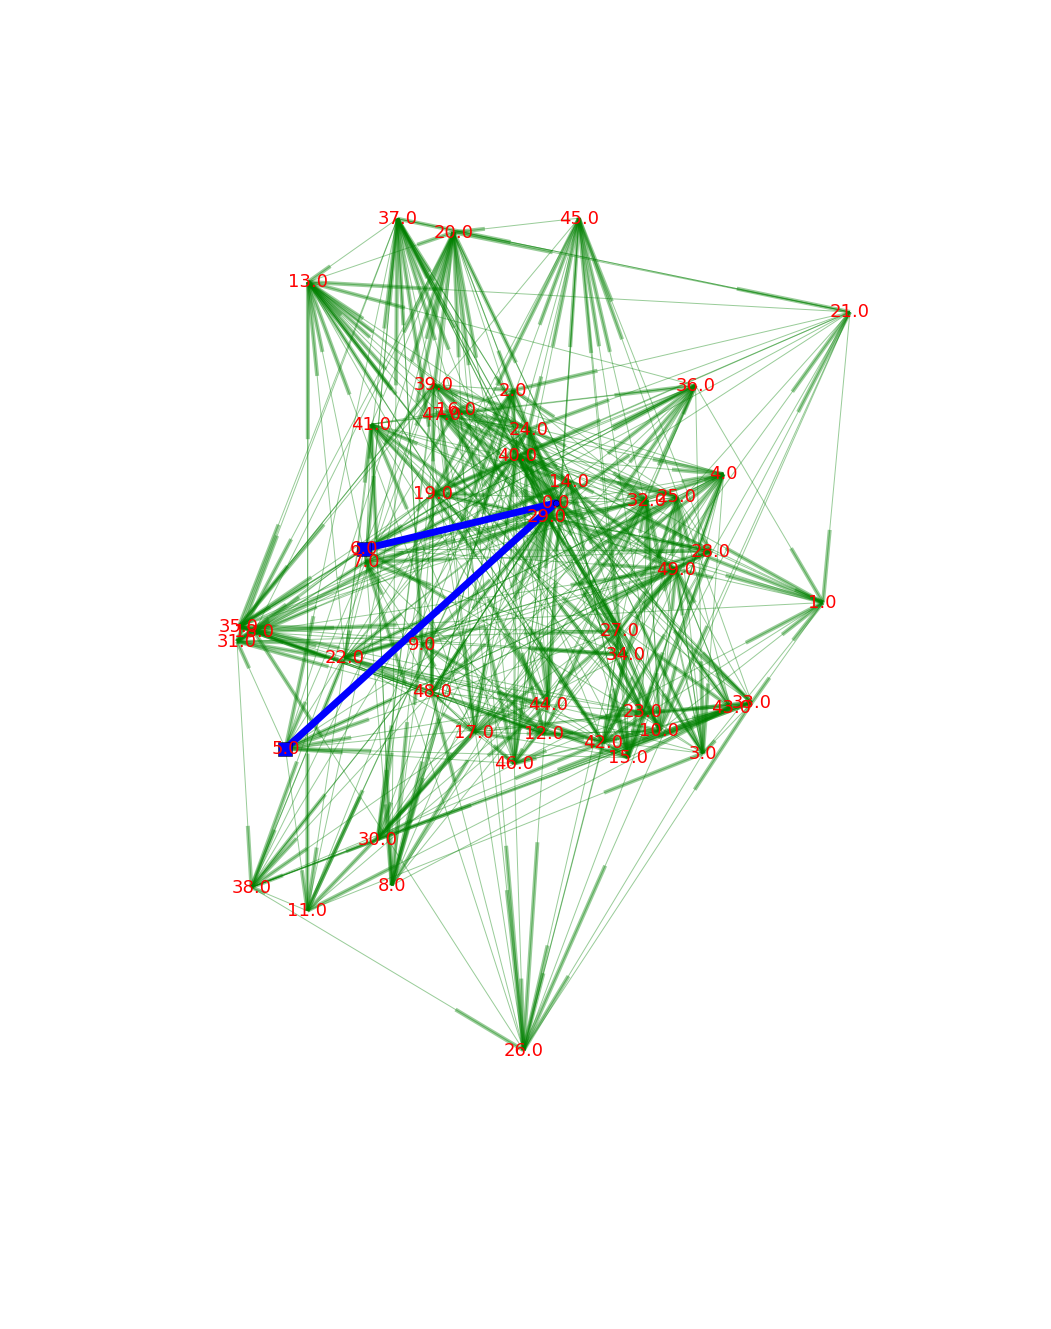

In [22]:
shrtpath_d = nx.shortest_path(graph1, j, k)
visualize_path(shrtpath_d, graph2)

## Problem 3 (30% of credit)

For the above spatial network B (defined by a weighted edge list dataB, nodes spatial locations XY) with given weigths $w$ from PB, fit the gravity model (over the entire network) 
$$
e(a,b)=k\cdot w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma},
$$
report the exponents $\alpha$, $\beta$, $\gamma$ and the statistics for the model fit. Visualize the model fit.

In [23]:
#Attributes
a = []
b = []
d = []
w = []

for i in dataB.index:
    A = int(dataB.a[i])
    B = int(dataB.b[i])
    a.append(PB.P[A])
    b.append(PB.P[B])
    w.append(dataB.w[i])
    # Euclidean distance
    d.append(np.linalg.norm(np.array([XY.X[A],XY.Y[A]]) - np.array([XY.X[B],XY.Y[B]])))

#Dataframe with attributes    
df = pd.DataFrame({'a': a, 'b': b, 'dist': d, 'weight': w})

                            OLS Regression Results                            
Dep. Variable:            log(weight)   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2159.
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        14:10:14   Log-Likelihood:                -3198.6
No. Observations:                2450   AIC:                             6405.
Df Residuals:                    2446   BIC:                             6428.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.0960      0.120    -42.518      0.0

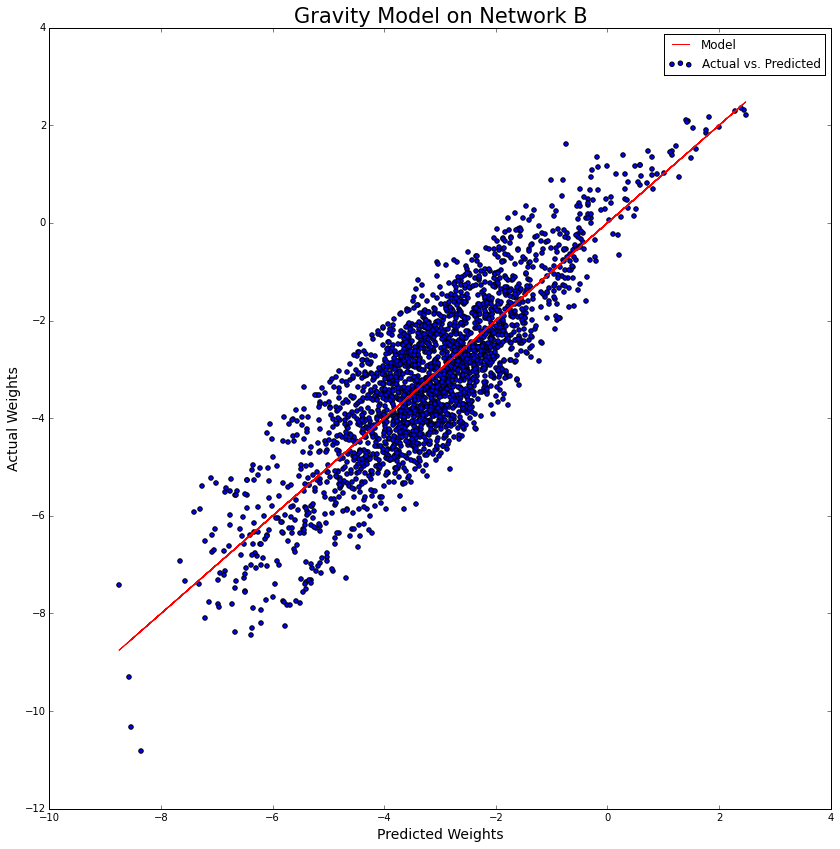

In [24]:
#Gravity model
mod = smf.ols(formula='log(weight) ~ log(dist)+log(a)+log(b)', data=df).fit()
print mod.summary()
p = mod.predict(df)

# Plot
figure, ax = plt.subplots(figsize=(14,14))
ax.scatter(p,log(df.weight),label='Actual vs. Predicted')
ax.plot(p,p,'r',label='Model')
ax.set_title('Gravity Model on Network B', fontsize = 21)
ax.set_xlabel('Predicted Weights',fontsize = 14)
ax.set_ylabel('Actual Weights', fontsize = 14)
ax.legend()

From above we can see that $\alpha$ = 0.8954, $\beta$ = 1.5160 and $\gamma$ = -1.6171

## Problem 4 (30% of credit)

For the above spatial network B with given weigths $w$ and given the total strength of outgoing edges $T(a)$ estimated from the network data for each node $a$, fit the locally normalized model (over the entire network)
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_{c\neq a} w(c)^\beta d(a,c)^{-\gamma}},
$$
report the exponents $\beta$, $\gamma$. Estimate $R2$ for the fit in the log-scale of the original network. Visualize the model fit.

In [25]:
graph3 = nx.DiGraph()

for i in dataB.index:
    A = int(dataB.a[i])
    B = int(dataB.b[i])
    
    graph3.add_edge(
        A, B, 
        weight=dataB.w[i], 
        dist=np.linalg.norm(np.array([XY.X[A],XY.Y[A]]) - np.array([XY.X[B],XY.Y[B]]))
    )

In [26]:
# function locally normalized gravity model fit (in terms of log-scale R2) for given exponents q
def LNGmodel(q,G,G_w):
    #first pass - assign relative weights as the model prediction
    for e in G.edges():
        if e[0]!=e[1]:
            G[e[0]][e[1]]['predict']=(G[e[0]][e[1]]['dist']**q[0])*(G_w[e[1]]**q[1])
            
    #compute normalization factors    
    G_norm=G.out_degree(weight='predict')
    G_wout=G.out_degree(weight='weight')
    for a in G.nodes():
        G_norm[a]=(G_wout[a])/(G_norm[a])

    E = []
    E = map(float,E)
    me = []
    me = map(float, me)
    for e in G.edges():
        if e[0]!=e[1]:
            E.append(G[e[0]][e[1]]['weight'])
            me.append(G[e[0]][e[1]]['predict']*G_norm[e[0]])

    E = np.array(E).astype(float)
    me = np.array(me).astype(float)

    R2=1-sum(pow(log(E)-log(me),2))/sum(pow(log(E)-mean(log(E)),2)) 
    return (R2,E,me) #performance and edge weights-predictions for fit visualization purposes 

def LNGmodelFit(q,G,G_w):
    #version for maximization
    return -LNGmodel(q,G,G_w)[0]

In [27]:
res=optimize.minimize(LNGmodelFit,[1, 1],method='Nelder-Mead',args=(graph3,PB.P))
print res

  status: 0
    nfev: 97
 success: True
     fun: -0.98340992687397832
       x: array([-2.02919103,  1.48648881])
 message: 'Optimization terminated successfully.'
     nit: 51


In [28]:
(R2,e,me)=LNGmodel(res.x,graph3,PB.P)
print R2, res.x

0.983409926874 [-2.02919103  1.48648881]


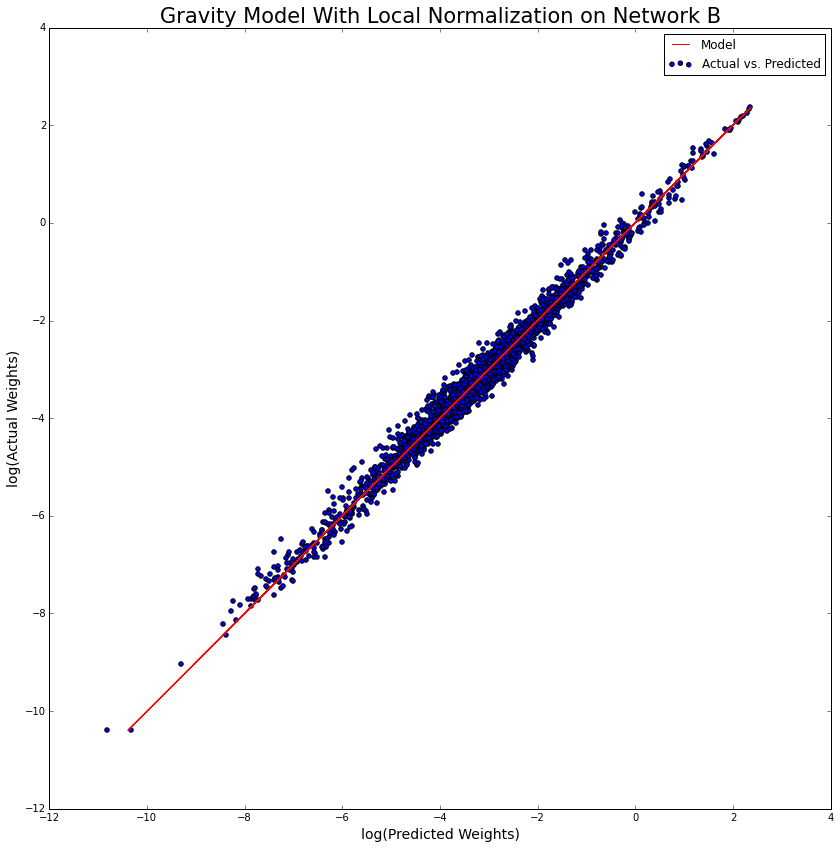

In [29]:
figure, ax = plt.subplots(figsize=(14,14))
ax.scatter(log(w),log(me),label='Actual vs. Predicted')
ax.plot(log(me),log(me),'r',label='Model')
ax.set_title('Gravity Model With Local Normalization on Network B', fontsize = 21)
ax.set_xlabel('log(Predicted Weights)', fontsize = 14)
ax.set_ylabel('log(Actual Weights)', fontsize = 14)
ax.legend()

From the summary (printed inthe cell above the graph), we can tell that $\beta$ = 1.48648881, $\gamma$ = -2.02919103 and $\log(R^2)$ = 0.983409926874

## Extracredit assignment (additional 50% of credit to be applied to this or any past assignment)

Implement radiation model and apply it to US migration data. Visualize the fit. Compare it (visually and quantitatively (R2)) to that of the gravity models with global and local normalization (fitted over the entire dataset).